# Cluster and Prediction using RCNN

Our task is [Movie Review Sentiment Analysis](https://www.kaggle.com/c/movie-review-sentiment-analysis-kernels-only), where we classify the sentiment of sentences from the Rotten Tomatoes dataset. Data contains the phrases and their associaed sentiment labels. The sentiment labels are: 0 (negative), 1 (somewhat negative), 2 (neutral), 3 (somewhat positive), 4 (positive).

Our strategy is to use clustering algorithms before preditive models. When the problem is complex, it would be helpful to split data into several sets. With distanced based similarity, we will group data points before training our deep learning model. Let's see how this process affects the performance of model. 

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, re, string
#print(os.listdir("../input"))

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU, BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.layers import Dense, Input, GlobalMaxPooling1D 
from keras.layers import Conv1D, MaxPooling1D, Embedding # 1-d operation
from keras.models import Model
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist

ps = PorterStemmer()
lm = WordNetLemmatizer()

import pickle
def save(data, name):
    filehandler = open(name, "wb")
    pickle.dump(data, filehandler)
    filehandler.close()
def load(name):
    filehandler = open(name, "rb")
    return pickle.load(filehandler)

#train = pd.read_csv('../input/movie-review-sentiment-analysis-kernels-only/train.tsv', sep="\t")
#test = pd.read_csv('../input/movie-review-sentiment-analysis-kernels-only/test.tsv', sep="\t")
#sub = pd.read_csv('../input/movie-review-sentiment-analysis-kernels-only/sampleSubmission.csv', sep=",")
train = pd.read_csv('train.tsv', sep="\t")
test = pd.read_csv('test.tsv', sep="\t")
sub = pd.read_csv('sampleSubmission.csv', sep=",")

# Data Exploration

Let's explore our dataset before modeling.

In [18]:
train.head(10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


There are null or all-space strings in Phrase column. To solve this dummy values, we consider such strings as "DUMMY".

In [19]:
train["Phrase"] = train["Phrase"].fillna("DUMMY").values
test["Phrase"] = test["Phrase"].fillna("DUMMY").values

def space_handling(str_):
    if str_.isspace() == True: return 'DUMMY'
    else: return str_ 
    
train["Phrase"] = train["Phrase"].apply(space_handling)
test["Phrase"] = test["Phrase"].apply(space_handling)

There is "DUMMY" in 2005th row. 

In [20]:
train.loc[train.SentenceId == 76]

,PhraseId,SentenceId,Phrase,Sentiment
2005,2006,76,DUMMY,1
2006,2007,76,Contrived pastiche of caper,2
2007,2008,76,Contrived pastiche,2
2008,2009,76,Contrived,1
2009,2010,76,pastiche,2
2010,2011,76,of caper,2
2011,2012,76,caper,2


It is important to calculate statistics of data. Here are some statistics of our data. (Ref. [Andrew Lukyanenko](https://www.kaggle.com/artgor/movie-review-sentiment-analysis-eda-and-models))

In [21]:
print('Average count of phrases per sentence in train is {0:.0f}.'.format(train.groupby('SentenceId')['Phrase'].count().mean()))
print('Average count of phrases per sentence in test is {0:.0f}.'.format(test.groupby('SentenceId')['Phrase'].count().mean()))
print('\n')
print('Number of phrases in train: {}. Number of sentences in train: {}.'.format(train.shape[0], len(train.SentenceId.unique())))
print('Number of phrases in test: {}. Number of sentences in test: {}.'.format(test.shape[0], len(test.SentenceId.unique())))
print('\n')
print('Average word length of phrases in train is {0:.0f}.'.format(np.mean(train['Phrase'].apply(lambda x: len(x.split())))))
print('Average word length of phrases in test is {0:.0f}.'.format(np.mean(test['Phrase'].apply(lambda x: len(x.split())))))
print('\n')
print('Maximum word length of phrases in train is {0:.0f}.'.format(np.max(train['Phrase'].apply(lambda x: len(x.split())))))
print('Maximum word length of phrases in test is {0:.0f}.'.format(np.max(test['Phrase'].apply(lambda x: len(x.split())))))
print('\n')
print('Minimum word length of phrases in train is {0:.0f}.'.format(np.min(train['Phrase'].apply(lambda x: len(x.split())))))
print('Minimum word length of phrases in test is {0:.0f}.'.format(np.min(test['Phrase'].apply(lambda x: len(x.split())))))
print('\n')

Average count of phrases per sentence in train is 18.
Average count of phrases per sentence in test is 20.


Number of phrases in train: 156060. Number of sentences in train: 8529.
Number of phrases in test: 66292. Number of sentences in test: 3310.


Average word length of phrases in train is 7.
Average word length of phrases in test is 7.


Maximum word length of phrases in train is 52.
Maximum word length of phrases in test is 56.


Minimum word length of phrases in train is 1.
Minimum word length of phrases in test is 1.




In general, neural network models require fixed input length. To choose the fixed input length, we refer to the maximum word length of phrases in train data. In our case, maximumm word length is 52. We choose **60 fixed input length** for safety margins. If the length of data points in test set over 60, we must trim out. Note that we always keep from considering the statistics of test set because it is cheating. 

In [22]:
MAX_NUM_WORDS = 60 

It is also worthy to the ratios of phrases and sentences. (Ref. [Vinh Dang](https://www.kaggle.com/dangvinh/word2vec-feature-with-cnn-model))

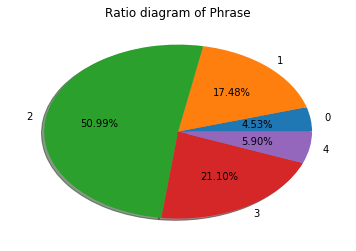

In [23]:
labels = ["0", "1", "2", "3", "4"]
numberPhrase = train.groupby("Sentiment").count().PhraseId
plt.pie(list(numberPhrase), labels=labels, autopct='%.2f%%', shadow=True)

plt.title('Ratio diagram of Phrase')
plt.show()

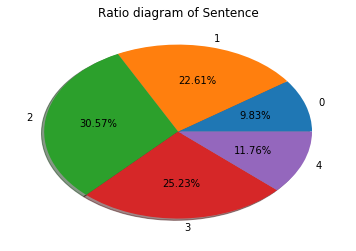

In [24]:
numberSentence = train.groupby("Sentiment").SentenceId.nunique()
plt.pie(list(numberSentence), labels=labels, autopct='%.2f%%', shadow=True)
plt.title('Ratio diagram of Sentence')
plt.show()

# Data Preprocessing

When we doing text analysis, it is necessary to do preprocessing for resolve sparsity problem. Also, we can make the best use of the power of pre-trained word embedding. We use light version of text preprocessing because some phrases have only a single non-semantic word.

* do lowering
* do lemmatazing
* retain stop-words 
* retrian puncutations
* filter out non-frequent words (thr=3)


Even non-semantic words such as stop-words and punctuations can be data points. Here is an example. 'This' and 'and' are individually the whole phrases. 'Dot' can have semantic meaning in that 'is worth seeking .' vs. 'is worth seeking'. We assume that the same situations exist in our dataset. 

In [25]:
train.loc[train.SentenceId == 2]

,PhraseId,SentenceId,Phrase,Sentiment
63,64,2,"This quiet , introspective and entertaining in...",4
64,65,2,"This quiet , introspective and entertaining in...",3
65,66,2,This,2
66,67,2,"quiet , introspective and entertaining indepen...",4
67,68,2,"quiet , introspective and entertaining",3
68,69,2,quiet,2
69,70,2,", introspective and entertaining",3
70,71,2,introspective and entertaining,3
71,72,2,introspective and,3
72,73,2,introspective,2


In [26]:
def gen_prep(doc): # general preprocessing
    
    # recover
    doc = re.sub(r"\'s", " is", doc) 
    doc = re.sub(r"\'ve", " have", doc) 
    doc = re.sub(r"n\'t", " not", doc) 
    doc = re.sub(r"\'re", " are", doc) 
    doc = re.sub(r"\'d", " would", doc) 
    doc = re.sub(r"\'ll", " will", doc)     
    
    # DEFAULT
    tokens = doc.split() # split by whitespace
    
    ##############################
    """ Deformation  """
    ##############################
    ### Lowerring
    tokens = [word.lower() for word in tokens] # lower
    ### Normalization
    #tokens = [ps.stem(word) for word in tokens] # stemming
    tokens = [lm.lemmatize(word) for word in tokens] # lemmatizing
    ### Remove Punctuation & Tokenization
    #re_punc = re.compile('[%s]' % re.escape(string.punctuation)) # except for '.'
    #tokens = [re_punc.sub(' ', w) for w in tokens] # Removing Punctuation   
    #temp=[]
    #for each in tokens:
    #    temp += each.split()
    #tokens = temp[:]
    
    ##############################
    """ Deletion  """
    ##############################
    # remove non-alphabetic tokens
    #SLMP_N_tokens = [word for word in SLMP_tokens if word.isalpha()] 
    # remove stop-words
    #stop_words = set(stopwords.words('english')) 
    #SLMP_T_tokens = [word for word in SLMP_tokens if not word in stop_words]
    # remove non-freq words (limit to document-level)
    #SLMP_TF_tokens = [word for word in SLMP_T_tokens if len(word) > 2]  
    return ' '.join(tokens)

def filter_prep(doc, vocab):
    doc_li = doc.split()
    tokens_li = [w for w in doc_li if w in vocab]
    return ' '.join(tokens_li)

# Do preprocessing both train and test set
train['Phrase'] = train['Phrase'].apply(gen_prep)
test['Phrase'] = test['Phrase'].apply(gen_prep)

We build a vocabulary for fitering out non-frequent words.

In [27]:
### Build vocabuary using only train data
from collections import Counter
vocab = Counter()
for i, each in train.iterrows():
    vocab.update(each['Phrase'].split()) # arg: ['word1', 'word2', 'word3', ...]
min_occurane = 3 # 0: do not filter
vocab = [k for k,c in vocab.items() if c > min_occurane]    

train['Phrase'] = train['Phrase'].apply(lambda x: filter_prep(x, vocab))
test['Phrase'] = test['Phrase'].apply(lambda x: filter_prep(x, vocab))

VOCAB_SIZE = len(vocab) + 1 # add UNK
print('Size of vocab: ', VOCAB_SIZE)

Size of vocab:  14893


# Data Vectorization

In order for computers understand data, we transform each data point to numerial vector form. We will use word embedding for including syntactic and sematic information.

First step, we transform data point into vocabulary index by using `Tokenizer` and add zero padding using `pad_sequences`.

In [28]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE,
                      filters = '', 
                      lower = False) # 두 가지 일을 함: (1) 토큰으로 쪼갬 (2) 토큰을 숫자로 변경

phrases = train["Phrase"].values
tokenizer.fit_on_texts(phrases)
word2idx = tokenizer.word_index 
print('Unique tokens: ', len(word2idx)) # it is the same as vocab size

# for train data
phrases = tokenizer.texts_to_sequences(phrases)
train_ = pad_sequences(phrases, maxlen = MAX_NUM_WORDS)
print('Shape of train tensor: ', train_.shape)

# for test data
test_phrases = test["Phrase"].values
test_phrases = tokenizer.texts_to_sequences(test_phrases)
test_ = pad_sequences(test_phrases, maxlen = MAX_NUM_WORDS)
print('Shape of test tensor: ', test_.shape)

Unique tokens:  14892
Shape of train tensor:  (156060, 60)
Shape of test tensor:  (66292, 60)


There are many different pretrained word embedding in online: skip-gram, GloVe, fastText. Among them, We will use GloVe pretrained word embedding. (Ref. [Stanford NLP Group: GloVe](https://nlp.stanford.edu/projects/glove/)). We save it as pickle for accessibility.

In [29]:
# # Loading Word Vectors
# print('Loading word vectors...')
# word2vec = {}
# with open(os.path.join('glove.42B.300d.txt'), encoding='UTF8') as f:
#     # is just a space-separated text file in the format:
#     # word vec[0] vec[1] vec[2] ...
#     for line in f:
#         values = line.split()
#         word = values[0]
#         vec = np.asarray(values[1:], dtype='float32')
#         word2vec[word] = vec
# print('Found %s word vectors.' % len(word2vec))

# save(word2vec, 'glove_42B_300d')
#word2vec = load('../input/glove-42b-300d-pickle/glove_42B_300d')
word2vec = load('glove_42B_300d')
EMBEDDING_DIM = 300

# embedding matrix
#num_words = min(VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < VOCAB_SIZE:
        embedding_vector = word2vec.get(word) # get function: if null, print None (not exception)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros. 
            embedding_matrix[i] = embedding_vector

# Document Representation

In order to using clustering algorithms, we need a single vector for each point (not multiple vectors). A simple way to combine multiple vectors is to average them. That is, we element-wisely average word vectors for building document vector.

In [30]:
print('Shape of train tensor: ', train_.shape)

Shape of train tensor:  (156060, 60)


In [31]:
train_doc = []
for i, word in enumerate(train_):
    sum_emb = np.zeros(EMBEDDING_DIM)
    for j, _ in enumerate(word):
        sum_emb += embedding_matrix[train_[i][j]] # sum
    train_doc.append(sum_emb / MAX_NUM_WORDS) # average
print('Length of train document: ', len(train_doc))

test_doc = []
for i, word in enumerate(test_):
    sum_emb = np.zeros(EMBEDDING_DIM)
    for j, _ in enumerate(word):
        sum_emb += embedding_matrix[test_[i][j]] # sum
    test_doc.append(sum_emb / MAX_NUM_WORDS) # average
print('Length of train document: ', len(test_doc))

Length of train document:  156060
Length of train document:  66292


# Clustering

We will use K-means algorithm for clustering. K-means needs the optimal number of clusters. For that, we use Elbow method. 

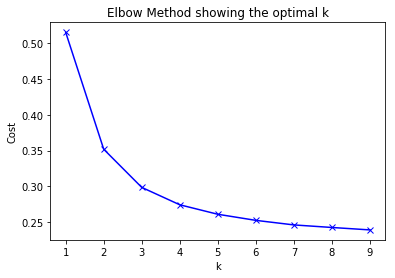

In [32]:
##############################################
""" Find the optimal k using Elbow Method """
##############################################

# k means determine k
costs = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(train_doc)
    kmeanModel.fit(train_doc)
    costs.append(sum(np.min(cdist(train_doc, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / len(train_doc))
    
# Plot the elbow
plt.plot(K, costs, 'bx-')
plt.xlabel('k')
plt.ylabel('Cost')
plt.title('Elbow Method showing the optimal k')
plt.show()

As you see the above plot, k=3 seems the Elbow point because the trend is saturated starting from it.

In [33]:
NUM_CLUSTERS = 3
kmeans = KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(train_doc)
print('Shape of centroids from K-means: ', kmeans.cluster_centers_.shape)

Shape of centroids from K-means:  (3, 300)


# Train & Test Predictive Models

In this part, we define a neural network model and train and test it. Remember, we will use multiple models according to the results of clustering.

We divide the whole data into several subsets based on the euclidean distance with learned centroids. 

In [34]:
# for train
train_doc_dist = cdist(train_doc, kmeans.cluster_centers_, 'euclidean')
train_index = [x.tolist().index(min(x)) for x in train_doc_dist]

# for test
test_doc_dist = cdist(test_doc, kmeans.cluster_centers_, 'euclidean')
test_index = [x.tolist().index(min(x)) for x in test_doc_dist]

def subset_train(X, y, idx_, clusterID):
    subX = []
    suby = []
    phraseID = []
    for i, _ in enumerate(X):
        if idx_[i] == clusterID:
            subX.append(X[i])
            suby.append(y[i])
    assert(len(subX) == len(suby))
    return np.array(subX), np.array(suby)

def subset_test(X, idx_, PhraseId, clusterID):
    subX = []
    phraseId = []
    for i, _ in enumerate(X):
        if idx_[i] == clusterID:
            subX.append(X[i])
            phraseId.append(PhraseId[i])
    return np.array(subX), np.array(phraseId)

Neural networks models have good performance for text predictive problems. The representative neural models are convolutional and recurrent models. Convolutional models captures short temporal dependencies with sparse connections. Recurrent models recognizes long temporal correlations with recurrent structures. These days, there are many researches to combine both models. It leads to get benefits from both side.

From this apsect, we build a recurrent convolutional neural network (RCNN) for our task. We have 5-depth RCNN modules, where at each depth, the united representation in temporal-size is drwan by global max pooling and the final representation is made by concatinating them. (Model Design inspired by [Andrew Lukyanenko](https://www.kaggle.com/artgor/movie-review-sentiment-analysis-eda-and-models)) 

In [42]:
def define_RCNN_model():
    
    input_ = Input(shape = (MAX_NUM_WORDS,))
    x = Embedding(VOCAB_SIZE, 
                  EMBEDDING_DIM, 
                  weights = [embedding_matrix], 
                  trainable = True # notice this: True
                 )(input_)
    x = SpatialDropout1D(0.5)(x)
    
    x1 = Bidirectional(GRU(128, return_sequences = True))(x)
    x1 = Conv1D(64, kernel_size=3, padding='valid', kernel_initializer='he_uniform')(x1)
    max_x1 = GlobalMaxPooling1D()(x1)
        
    x2 = Bidirectional(GRU(128, return_sequences = True))(x1)
    x2 = Conv1D(64, kernel_size=3, padding='valid', kernel_initializer='he_uniform')(x2)
    max_x2 = GlobalMaxPooling1D()(x2)
    
    x3 = Bidirectional(GRU(128, return_sequences = True))(x2)
    x3 = Conv1D(64, kernel_size=3, padding='valid', kernel_initializer='he_uniform')(x3)
    max_x3 = GlobalMaxPooling1D()(x3)
    
    x = concatenate([max_x1, max_x2, max_x3])
    x = Dense(128, activation = "tanh")(x)
    x = Dropout(0.5)(x)
    
    output = Dense(5, activation = "softmax")(x)
    
    model = Model(inputs = input_, outputs = output)
    model.compile(loss = "categorical_crossentropy", 
                  optimizer = 'rmsprop', 
                  metrics = ["accuracy"])
    
    return model

In [43]:
define_RCNN_model().summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 60)           0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 60, 300)      4467900     input_8[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_8 (SpatialDro (None, 60, 300)      0           embedding_8[0][0]                
__________________________________________________________________________________________________
bidirectional_36 (Bidirectional (None, 60, 256)      329472      spatial_dropout1d_8[0][0]        
__________________________________________________________________________________________________
conv1d_36 

Since we need to use multiple neural models, the new process is as follows:

In [45]:
sorted_pred = [-1] * len(test)
models = []
acc = []
for cluster_ID in range(0, NUM_CLUSTERS):

    print('Cluster ID: ', cluster_ID)
    X_train, y_train = subset_train(train_, 
                                    train['Sentiment'].values, 
                                    train_index, 
                                    cluster_ID)
    
    model = define_RCNN_model()
    model.fit(X_train,
              pd.get_dummies(y_train).values,
              epochs = 20,
              batch_size = 128,
              verbose=0)
    
    
    X_test, test_pId = subset_test(test_, 
                                    test_index, 
                                    test['PhraseId'].values,
                                    cluster_ID)  
    
    pred = model.predict(X_test)
    
    #pred = model.evaluate(X_test,
    #                     pd.get_dummies(y_train).values)
    argmax_pred = np.argmax(pred, axis=1)
    
    for i, _ in enumerate(test_pId):
        sorted_pred[ test_pId[i] - 156061 ] = argmax_pred[i]
        
# save the results
sub['Sentiment'] = sorted_pred
sub.to_csv("n_clusters.csv", index=False)

Cluster ID:  0
Cluster ID:  1
Cluster ID:  2


To see benefits of clustering process, we need to check the performance when we do not use clustering algorithm. Here is ordinary process:

In [46]:
model2 = define_RCNN_model()
model2.fit(train_,
          pd.get_dummies(train['Sentiment'].values).values,
          epochs = 20,
          batch_size = 128,
          verbose=0)
    
pred = model2.predict(test_)
#pred = model.evaluate(X_test,
#                     pd.get_dummies(y_train).values)
argmax_pred = np.argmax(pred, axis=1)

# save the results
sub['Sentiment'] = argmax_pred
sub.to_csv("1_clusters.csv", index=False)

# Comparison of clustering

Results are:
* 1-cluster (without clustering):
* 3-cluster (with clsutering): 



# Conclusion

Our problem is to predict sentiment scores using review dataset and machine learning models. The strategy we are trying to do is to cluster data points before using predictive models. It is called 'cluster and predict'. We expect that such clustering process could reduce the complexity of data patterns. 

However, the performance when we use clustering algorithms is less than not use. The main reason why clustering not work is because word and document representations are not suitable. We need to design better ones. Also, we describe what we do next in Further Study. 

We expect that when we have better word and document representations, 'cluster and predict' method will be working.
<br>
(Since kernel system in Kaggle is abnormal, we did not upload this notebook) 

# Further Study

If we increase the performance of models, we need to do:

* design bettern word representation
   * tfidf
   * n-gram
* optimize hyper-parameters of models
   * epoch size, batch size, hidden size, ...
* design better document representation (averaging is very simple)
   * (maybe) we can use the final layer of traied neural models
* use better clustering algorithms
   * capture non-linearity
   * select the optimal number of clusters
* collect more training data
* apply ensemble methods
* apply various regularization techniques